# Compare QTLs for tomato fruit shape and potato tuber shape

## Background

Tomato fruits have a round shape while the potato tubers have an elongated shape. The candidate gene _Solyc10g076180_ ( _SlOFP20_ , a member of the OVATE family) on the chromosome 10 of the reference tomato genome (Heinz 1706) is responsible for round fruits. However, this gene does not have an ortholog in the reference potato genome (DM), which results in elongated tuber (<a href="https://dx.doi.org/10.1038%2Fs41467-018-07216-8">Wu et al., 2018</a>). This notebook uses the <a href="http://grlc.io/">grlc</a>-based Web API of the <a href="https://doi.org/10.5281/zenodo.1458168">pbg-ld</a> platform to map QTL regions for the traits in both tomato and potato as well as to retrieve annotations for the genes in the QTLs.

In [1]:
import io
import requests
import ipywidgets
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

try:
    from networkx.drawing.nx_pydot import graphviz_layout
except ImportError:
    raise ImportError("This example needs Graphviz and either PyGraphviz or Pydot")

from ipywidgets import interactive

In [2]:
# display-related options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width', 0)

In [3]:
# output files
outfiles = {'paralogs': 'paralogs.csv',
            'orthologs': 'orthologs.csv',
            'genes_annot': 'genes_annot.csv',
            'homologs_annot': 'homologs_annot.csv'}

In [4]:
# Web API
base_url = None
hosts = {'remote': 'http://pbg-ld.candygene-nlesc.surf-hosted.nl:8088/api/candYgene/queries',
         'local': 'http://localhost:8088/api/local/local'}
headers = {'accept': 'text/csv'} # request content in CSV

In [5]:
# create a widget with a drop-down list of hosts
def setWebAPI(host):
    print(host)
    return host
w = interactive(setWebAPI, host=hosts)

In [6]:
display(w) # default host 'remote'

interactive(children=(Dropdown(description='host', options={'remote': 'http://pbg-ld.candygene-nlesc.surf-host…

In [8]:
base_url = w.result
#print(base_url)

## Input genes

In [9]:
# tomato genes upstream/downstream of the candidate gene on chromosome 10
input_data = dict(tomato=dict(genes=['Solyc10g075170.1', 'Solyc10g076240.1'],
                              taxon_id=4081,
                              graph_iri='http://solgenomics.net/genome/Solanum_lycopersicum'))

In [10]:
# retrieve genomic locations for the genes
genes = pd.DataFrame()
for g in input_data['tomato']['genes']:
    try:
        if g is not None:
            with requests.get(base_url + '/getFeatureLocation',
                              params = {'featureid': "'%s'" % g},
                              headers = headers) as req:
                genes = genes.append(pd.read_csv(io.StringIO(req.text)), ignore_index=True)
    except:
        print('Failed to connect to the Web API!')
        break

In [11]:
display(genes)

,feature_id,feature_name,chrom,begin_pos,end_pos,taxon_id
0,Solyc10g075170.1,protein_coding_gene,chromosome 10,58891402,58895882,4081
1,Solyc10g076240.1,protein_coding_gene,chromosome 10,59082990,59084119,4081


In [12]:
# compute the QTL interval given the start/end positions of the genes
pos = pd.concat([genes['begin_pos'], genes['end_pos']]).describe()
qtl_inter = dict(chrom=genes['chrom'].unique()[0],
                 taxon_id=int(genes['taxon_id'].unique()[0]),
                 begin=int(pos['min']),
                 end=int(pos['max']))

In [13]:
display(qtl_inter)

{'chrom': 'chromosome 10',
 'taxon_id': 4081,
 'begin': 58891402,
 'end': 59084119}

In [14]:
# retrieve all genes in the genomic interval
genes_inter = pd.DataFrame()
params = {'feature': 'protein_coding_gene',
          'chrom': qtl_inter['chrom'],
          'graph': input_data['tomato']['graph_iri'],
          'begin': qtl_inter['begin'],
          'end': qtl_inter['end']}
try:
    with requests.get(base_url + '/getFeaturesInInterval',
                      params=params,
                      headers=headers) as req:
        genes_inter = pd.read_csv(io.StringIO(req.text))
except:
    print('Failed to connect to the Web API!')

In [15]:
display(genes_inter.sort_values(['chrom', 'begin_pos']))

,feature_id,feature_name,chrom,begin_pos,end_pos
0,Solyc10g075170.1,protein_coding_gene,chromosome 10,58891402,58895882
1,Solyc10g076170.1,protein_coding_gene,chromosome 10,58981351,58981887
2,Solyc10g076180.1,protein_coding_gene,chromosome 10,59006329,59007294
3,Solyc10g076190.1,protein_coding_gene,chromosome 10,59045991,59047132
4,Solyc10g076200.1,protein_coding_gene,chromosome 10,59051770,59052216
5,Solyc10g076210.1,protein_coding_gene,chromosome 10,59054478,59055612
6,Solyc10g076220.1,protein_coding_gene,chromosome 10,59059828,59060961
7,Solyc10g076230.1,protein_coding_gene,chromosome 10,59074041,59074647
8,Solyc10g076240.1,protein_coding_gene,chromosome 10,59082990,59084119


## Paralogs

In [16]:
# for each tomato gene retrieve its paralog(s)
rows = []
for index, g in genes_inter.iterrows():
    try:
        with requests.get(base_url + '/getParalogs',
                          params={'geneid': "'%s'" % g['feature_id']},
                          headers=headers) as req:
            df = pd.read_csv(io.StringIO(req.text))
            if df.size == 0:
                rows.append([g['feature_id'], g['chrom'], g['begin_pos'], g['end_pos'],
                             None, None, None, None]) # if paralog not found
                continue
            for index, j in df.iterrows():
                with requests.get(base_url + '/getFeatureLocation',
                    params={'featureid': "'%s'" % j['paralog_id']},
                    headers=headers) as req:
                    for index, o in pd.read_csv(io.StringIO(req.text)).iterrows():
                        rows.append([g['feature_id'], g['chrom'], g['begin_pos'], g['end_pos'],
                                     o['feature_id'], o['chrom'], o['begin_pos'], o['end_pos']])
  
    except:
        print('Failed to connect to the Web API!')
        break

In [17]:
# create a dataframe from the query results
cols = ['gene_id', 'chrom', 'begin', 'end', 'para_id', 'para_chrom', 'para_begin', 'para_end']
paralogs = pd.DataFrame(rows, columns=cols)
paralogs['para_begin'] = paralogs['para_begin'].fillna(-1)
paralogs['para_end'] = paralogs['para_end'].fillna(-1)
paralogs['para_begin'] = paralogs['para_begin'].astype(np.int64)
paralogs['para_end'] = paralogs['para_end'].astype(np.int64)
paralogs = paralogs.replace([-1], [None])\
                   .sort_values(['gene_id', 'para_chrom', 'para_begin'])

In [18]:
display(paralogs)

,gene_id,chrom,begin,end,para_id,para_chrom,para_begin,para_end
0,Solyc10g075170.1,chromosome 10,58891402,58895882,Solyc07g032740.2,chromosome 7,40981937,40987085
1,Solyc10g075170.1,chromosome 10,58891402,58895882,Solyc07g055210.2,chromosome 7,63320669,63325039
2,Solyc10g075170.1,chromosome 10,58891402,58895882,Solyc08g041870.2,chromosome 8,25450517,25456311
3,Solyc10g075170.1,chromosome 10,58891402,58895882,Solyc08g068330.2,chromosome 8,57428127,57436252
4,Solyc10g076170.1,chromosome 10,58981351,58981887,None,None,None,None
5,Solyc10g076180.1,chromosome 10,59006329,59007294,Solyc01g007800.2,chromosome 1,1955327,1956217
13,Solyc10g076180.1,chromosome 10,59006329,59007294,Solyc10g082050.1,chromosome 10,62944463,62944999
14,Solyc10g076180.1,chromosome 10,59006329,59007294,Solyc11g068780.1,chromosome 11,53412570,53412983
6,Solyc10g076180.1,chromosome 10,59006329,59007294,Solyc02g072030.1,chromosome 2,41330364,41331497
7,Solyc10g076180.1,chromosome 10,59006329,59007294,Solyc02g085500.2,chromosome 2,48367481,48369215


In [19]:
# write results into a CSV file
paralogs.set_index('gene_id').to_csv(outfiles['paralogs'])

In [20]:
# count paralogs per gene
display(paralogs.groupby(['gene_id'])['para_id']
        .agg(['count'])
        .sort_values(['count'], ascending=False)
        .rename(columns={'count':'n_paralogs'})
        .reset_index())

,gene_id,n_paralogs
0,Solyc10g076200.1,22
1,Solyc10g076190.1,11
2,Solyc10g076210.1,11
3,Solyc10g076220.1,11
4,Solyc10g076240.1,11
5,Solyc10g076180.1,10
6,Solyc10g075170.1,4
7,Solyc10g076230.1,1
8,Solyc10g076170.1,0


### Note: The gene _Solyc10g076170_ does not have a paralog in tomato.

In [21]:
# create a new dataframe with all genes in the interval including their paralogs
genes = paralogs[['para_id', 'para_chrom', 'para_begin', 'para_end']]\
        .query('para_id.notnull()')\
        .rename(columns=dict(para_id='gene_id', para_chrom='chrom', para_begin='begin', para_end='end'))
genes = genes.append(paralogs[['gene_id', 'chrom', 'begin', 'end']]).drop_duplicates()

In [22]:
display(genes.sort_values(['gene_id', 'chrom', 'begin']).reset_index(drop=True))

,gene_id,chrom,begin,end
0,Solyc01g007800.2,chromosome 1,1955327,1956217
1,Solyc01g081590.2,chromosome 1,80790002,80791273
2,Solyc01g081600.2,chromosome 1,80791839,80793152
3,Solyc01g090350.2,chromosome 1,84055544,84056304
4,Solyc01g090360.2,chromosome 1,84060227,84061028
5,Solyc02g072030.1,chromosome 2,41330364,41331497
6,Solyc02g085500.2,chromosome 2,48367481,48369215
7,Solyc02g087910.1,chromosome 2,50167356,50167715
8,Solyc03g025380.2,chromosome 3,2813769,2816283
9,Solyc03g034100.2,chromosome 3,5790338,5792106


## Orthologs

In [23]:
# for each tomato gene retrieve its ortholog(s) in potato
rows = []
for index, g in genes.iterrows():
    try:
        with requests.get(base_url + '/getOrthologs',
                          params={'geneid': "'%s'" % g['gene_id']},
                          headers=headers) as req:
            df = pd.read_csv(io.StringIO(req.text))
            if df.size == 0:
                rows.append([g['gene_id'], g['chrom'], g['begin'], g['end'],
                             None, None, None, None]) # if ortholog not found
                continue
            for index, j in df.iterrows():
                with requests.get(base_url + '/getFeatureLocation',
                    params={'featureid': "'%s'" % j['ortholog_id']},
                    headers=headers) as req:
                    for index, o in pd.read_csv(io.StringIO(req.text)).iterrows():
                        rows.append([g['gene_id'], g['chrom'], g['begin'], g['end'],
                                     o['feature_id'], o['chrom'], o['begin_pos'], o['end_pos']])  
    except:
        print('Failed to connect to the Web API!')
        break

In [24]:
# create a dataframe from the query results
cols = ['gene_id', 'chrom', 'begin', 'end', 'ortho_id', 'ortho_chrom', 'ortho_begin', 'ortho_end']
orthologs = pd.DataFrame(rows, columns=cols)
orthologs['ortho_begin'] = orthologs['ortho_begin'].fillna(-1)
orthologs['ortho_end'] = orthologs['ortho_end'].fillna(-1)
orthologs['ortho_begin'] = orthologs['ortho_begin'].astype(np.int64)
orthologs['ortho_end'] = orthologs['ortho_end'].astype(np.int64)
orthologs = orthologs.replace([-1], [None]).sort_values(['gene_id', 'ortho_chrom', 'ortho_begin'])

In [25]:
display(orthologs.reset_index(drop=True))

,gene_id,chrom,begin,end,ortho_id,ortho_chrom,ortho_begin,ortho_end
0,Solyc01g007800.2,chromosome 1,1955327,1956217,PGSC0003DMG400016415,chromosome 1,3359907,3360814
1,Solyc01g081590.2,chromosome 1,80790002,80791273,PGSC0003DMG400031126,chromosome 1,67141270,67142003
2,Solyc01g081600.2,chromosome 1,80791839,80793152,PGSC0003DMG400031127,chromosome 1,67139256,67140626
3,Solyc01g090350.2,chromosome 1,84055544,84056304,PGSC0003DMG400025988,chromosome 1,69558764,69559120
4,Solyc01g090360.2,chromosome 1,84060227,84061028,PGSC0003DMG400025987,chromosome 1,69566214,69566992
5,Solyc02g072030.1,chromosome 2,41330364,41331497,PGSC0003DMG400028460,chromosome 2,31424122,31425454
6,Solyc02g085500.2,chromosome 2,48367481,48369215,PGSC0003DMG400012688,chromosome 2,40752283,40754017
7,Solyc02g087910.1,chromosome 2,50167356,50167715,PGSC0003DMG400001322,chromosome 2,46262505,46262930
8,Solyc03g025380.2,chromosome 3,2813769,2816283,PGSC0003DMG400015801,chromosome 3,43497338,43500116
9,Solyc03g034100.2,chromosome 3,5790338,5792106,PGSC0003DMG400017788,chromosome 3,4403368,4405474


In [26]:
# write results into a CSV file
orthologs.set_index('gene_id').to_csv(outfiles['orthologs'])

In [27]:
# count orthologs per gene
display(orthologs.groupby(['gene_id'])['ortho_id']
        .agg(['count'])
        .sort_values(['count'], ascending=False)
        .rename(columns={'count':'n_orthologs'})
        .reset_index())

,gene_id,n_orthologs
0,Solyc10g075070.1,5
1,Solyc10g075090.1,3
2,Solyc10g076220.1,2
3,Solyc10g076210.1,2
4,Solyc10g076200.1,2
5,Solyc01g007800.2,1
6,Solyc01g081590.2,1
7,Solyc08g067550.1,1
8,Solyc08g068170.1,1
9,Solyc08g068330.2,1


### Note: Some tomato genes on chromosome 10, including the genes _Solyc10g076170_ and _Solyc10g076240_ surrounding the candidate gene  _Solyc10g076180_ , do not have an ortholog in potato.

## Gene annotations

In [28]:
# append potato orthologs to the tomato gene set (dataframe)
genes = genes.append(orthologs[['ortho_id', 'ortho_chrom', 'ortho_begin', 'ortho_end']]\
                     .query('ortho_id.notnull()')\
                     .rename(columns=dict(ortho_id='gene_id', ortho_chrom='chrom', ortho_begin='begin', ortho_end='end')))

In [29]:
# for each gene retrieve annotations from SGN, Ensembl Plants and UniProt/GOA
rows = []
for index, g in genes.iterrows():
    try:
        with requests.get(base_url + '/getGeneAnnotations',
                          params={'geneid': "'%s'" % g['gene_id']},
                          headers=headers) as req:
            df = pd.read_csv(io.StringIO(req.text))
            if df.size == 0:
                rows.append([g['gene_id'], g['chrom'], g['begin'], g['end'],
                             None, None, None, None, None, None, None]) # if annotations not found
                continue
            for index, h in df.iterrows():
                rows.append([g['gene_id'], g['chrom'], g['begin'], g['end'],
                             h['gene_name'], h['transcript_id'], h['uniprot_acc'], h['uniprot_reviewed'],
                             h['uniprot_des'], h['uniprot_goa'], h['sgn_des']])
    except:
        print('Failed to connect to the Web API!')
        break

In [30]:
# create a dataframe from the query results
cols = ['gene_id', 'chrom', 'begin', 'end', 'gene_name', 'transcript_id', 'uniprot_acc', 'uniprot_reviewed', 'uniprot_des', 'uniprot_goa', 'sgn_des']
genes_annot = pd.DataFrame(rows, columns=cols).sort_values(['gene_id', 'chrom', 'begin'])

In [31]:
display(genes_annot.reset_index(drop=True))

,gene_id,chrom,begin,end,gene_name,transcript_id,uniprot_acc,uniprot_reviewed,uniprot_des,uniprot_goa,sgn_des
0,PGSC0003DMG400001322,chromosome 2,46262505,46262930,102586194,PGSC0003DMT400003340,M0ZLH1,0,"Generated via protein_evidence_gt_2, Non-specific lipid-transfer protein",GO:0006869 [lipid transport]; GO:0008289 [lipid binding],name: Non-specific lipid-transfer protein
1,PGSC0003DMG400002471,chromosome 1,50944487,50945282,102585136,PGSC0003DMT400006324,M0ZR50,0,"Generated via protein_evidence_gt_2, Non-specific lipid-transfer protein",GO:0006869 [lipid transport]; GO:0008289 [lipid binding],name: Non-specific lipid-transfer protein
2,PGSC0003DMG400004418,chromosome 9,15532653,15533688,NaN,PGSC0003DMT400011286,M0ZZB6,0,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0003677 [DNA binding]; GO:0005730 [nucleolus]; GO:0005856 [cytoskeleton]; GO:0045892 [negative regulation of transcription, DNA-templated]; GO:0051510 [regulation of unidimensional cell growth]",name: ATOFP3/OFP3
3,PGSC0003DMG400004418,chromosome 9,15532653,15533688,NaN,PGSC0003DMT400011285,M0ZZB5,0,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]",name: ATOFP3/OFP3
4,PGSC0003DMG400006678,chromosome 10,48978066,48982521,NaN,PGSC0003DMT400017112,M1A8L1,0,"Generated via protein_evidence_gt_2, Uncharacterized protein",GO:0006520 [cellular amino acid metabolic process]; GO:0008483 [transaminase activity]; GO:0009058 [biosynthetic process]; GO:0030170 [pyridoxal phosphate binding],name: Aspartate aminotransferase
5,PGSC0003DMG400006678,chromosome 10,48978066,48982521,NaN,PGSC0003DMT400017110,M1A8K9,0,"Generated via protein_evidence_gt_2, Uncharacterized protein",GO:0006520 [cellular amino acid metabolic process]; GO:0008483 [transaminase activity]; GO:0009058 [biosynthetic process]; GO:0030170 [pyridoxal phosphate binding],name: Aspartate aminotransferase
6,PGSC0003DMG400006678,chromosome 10,48978066,48982521,NaN,PGSC0003DMT400017111,M1A8L0,0,"Generated via protein_evidence_gt_2, Uncharacterized protein",GO:0006520 [cellular amino acid metabolic process]; GO:0008483 [transaminase activity]; GO:0009058 [biosynthetic process]; GO:0030170 [pyridoxal phosphate binding],name: Aspartate aminotransferase
7,PGSC0003DMG400006678,chromosome 10,48978066,48982521,NaN,PGSC0003DMT400017113,M1A8L2,0,"Generated via protein_evidence_gt_2, Uncharacterized protein",GO:0006520 [cellular amino acid metabolic process]; GO:0008483 [transaminase activity]; GO:0009058 [biosynthetic process]; GO:0030170 [pyridoxal phosphate binding],name: Aspartate aminotransferase
8,PGSC0003DMG400006993,chromosome 5,45421783,45429898,NaN,PGSC0003DMT400018005,M1A9V9,0,"Generated via protein_evidence_gt_2, Uncharacterized protein",GO:0004601 [peroxidase activity]; GO:0006979 [response to oxidative stress]; GO:0020037 [heme binding],name: Class III peroxidase
9,PGSC0003DMG400006993,chromosome 5,45421783,45429898,NaN,PGSC0003DMT400018003,M1A9V8,0,"Generated via protein_evidence_gt_2, Uncharacterized protein",GO:0004601 [peroxidase activity]; GO:0006979 [response to oxidative stress]; GO:0020037 [heme binding]; GO:0042744 [hydrogen peroxide catabolic process]; GO:0046872 [metal ion binding],name: Class III peroxidase


In [32]:
# write results into a CSV file
genes_annot.set_index('gene_id').to_csv(outfiles['genes_annot'])

## Visualize _Solyc10g076180_ homologs and their relationships in a graph

In [33]:
gene_id = 'Solyc10g076180.1'
edges_para = paralogs.query("gene_id == @gene_id")[['gene_id', 'para_id']]
display(edges_para.reset_index(drop=True))

,gene_id,para_id
0,Solyc10g076180.1,Solyc01g007800.2
1,Solyc10g076180.1,Solyc10g082050.1
2,Solyc10g076180.1,Solyc11g068780.1
3,Solyc10g076180.1,Solyc02g072030.1
4,Solyc10g076180.1,Solyc02g085500.2
5,Solyc10g076180.1,Solyc03g034100.2
6,Solyc10g076180.1,Solyc04g080210.1
7,Solyc10g076180.1,Solyc06g082460.1
8,Solyc10g076180.1,Solyc08g068170.1
9,Solyc10g076180.1,Solyc09g018200.1


In [34]:
gene_ids =  set([gene_id]) | set(edges_para['para_id']) # add input gene and its paralogs to the set
edges_ortho = orthologs.query('gene_id in @gene_ids')[['gene_id', 'ortho_id']]
display(edges_ortho.reset_index(drop=True))

,gene_id,ortho_id
0,Solyc01g007800.2,PGSC0003DMG400016415
1,Solyc02g072030.1,PGSC0003DMG400028460
2,Solyc02g085500.2,PGSC0003DMG400012688
3,Solyc03g034100.2,PGSC0003DMG400017788
4,Solyc04g080210.1,PGSC0003DMG400044629
5,Solyc06g082460.1,PGSC0003DMG400030384
6,Solyc08g068170.1,PGSC0003DMG400014511
7,Solyc09g018200.1,PGSC0003DMG400004418
8,Solyc10g076180.1,None
9,Solyc10g082050.1,PGSC0003DMG400028155


/home/arnikz/local/miniconda3/envs/pbg-ld/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


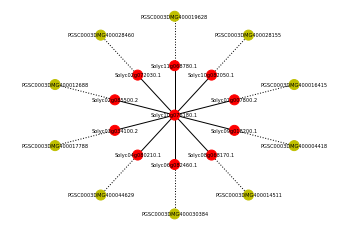

In [35]:
# plot a graph of tomato/potato genes (nodes) and ortho/paralogous relations (edges)
G = nx.Graph()
edges_ortho = edges_ortho.query('ortho_id.notnull()')
G.add_edges_from(edges_para.values, style='-')  # add paralogous relations (solid edges)
G.add_edges_from(edges_ortho.values, style=':') # add orthologous relations (dotted edges)
style_map = [G[u][v]['style'] for u,v in G.edges()]
color_map = []
for i,n in enumerate(G.nodes()):
    if 'Solyc' in n:
        color_map.append('r') # tomato genes in red
    else:
        color_map.append('y') # potato genes in yellow
pos = graphviz_layout(G, prog='twopi')
plt.margins(0.2, 0.05)
nx.draw(G, pos, node_size=100, node_color=color_map, style=style_map, font_size=5, with_labels=True)
plt.savefig('homologs_graph.svg')

In [36]:
# show genes annotations for the graph nodes
gene_ids |=  set(edges_ortho['ortho_id']) # append orthologs
homologs_annot = genes_annot.query('gene_id in @gene_ids').sort_values(['gene_id', 'chrom', 'begin'])
display(homologs_annot.reset_index(drop=True))

,gene_id,chrom,begin,end,gene_name,transcript_id,uniprot_acc,uniprot_reviewed,uniprot_des,uniprot_goa,sgn_des
0,PGSC0003DMG400004418,chromosome 9,15532653,15533688,NaN,PGSC0003DMT400011286,M0ZZB6,0,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0003677 [DNA binding]; GO:0005730 [nucleolus]; GO:0005856 [cytoskeleton]; GO:0045892 [negative regulation of transcription, DNA-templated]; GO:0051510 [regulation of unidimensional cell growth]",name: ATOFP3/OFP3
1,PGSC0003DMG400004418,chromosome 9,15532653,15533688,NaN,PGSC0003DMT400011285,M0ZZB5,0,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]",name: ATOFP3/OFP3
2,PGSC0003DMG400012688,chromosome 2,40752283,40754017,NaN,PGSC0003DMT400033048,M1AYJ0,0,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]",name: Ovate protein
3,PGSC0003DMG400014511,chromosome 8,43072980,43074248,NaN,PGSC0003DMT400037629,M1B5M3,0,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]",name: ATOFP8/OFP8
4,PGSC0003DMG400016415,chromosome 1,3359907,3360814,102586159,PGSC0003DMT400042334,M1BCV1,0,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]",name: Conserved gene of unknown function
5,PGSC0003DMG400017788,chromosome 3,4403368,4405474,102580284,PGSC0003DMT400045857,M1BIB0,0,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]",name: Ovate
6,PGSC0003DMG400019628,chromosome 11,40682903,40683552,107057995,PGSC0003DMT400050511,M1BQE8,0,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]",name: ATOFP6/OFP6
7,PGSC0003DMG400028155,chromosome 10,56030393,56031156,102586649,PGSC0003DMT400072347,M1CQ43,0,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]",name: Conserved gene of unknown function
8,PGSC0003DMG400028460,chromosome 2,31424122,31425454,102580543,PGSC0003DMT400073252,M1CRN9,0,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0045892 [negative regulation of transcription, DNA-templated]",name: ATOFP5/OFP5
9,PGSC0003DMG400030384,chromosome 6,57574904,57576476,102602169,PGSC0003DMT400078126,M1CZF8,0,"Generated via protein_evidence_gt_2, Uncharacterized protein","GO:0003677 [DNA binding]; GO:0045892 [negative regulation of transcription, DNA-templated]",name: Conserved gene of unknown function


In [37]:
# write results into a CSV file
homologs_annot.set_index('gene_id').to_csv(outfiles['homologs_annot'])